In [1]:
import ast
from typing import Annotated, Callable, Optional

from dotenv import load_dotenv
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from pydantic import BaseModel, Field
from typing_extensions import TypedDict

load_dotenv()

model = ChatOpenAI(model="gpt-4o-turbo-preview", temperature=0)
db = SQLDatabase.from_uri("sqlite:///chinook.db")


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    first_name: str
    last_name: str


# ------------------------------------------------------------------------------
# Define Tools
# ------------------------------------------------------------------------------


@tool
def get_customer_role_and_id(config: RunnableConfig):
    """Gets customer role and ID from Chinook DB"""
    try:

        configuration = config.get("configurable", {})
        first_name = configuration.get("first_name", None)
        last_name = configuration.get("last_name", None)

        if not first_name or not last_name:
            raise ValueError("First and last name are required")
        # Check employees
        employees = db.run(
            f"""
            SELECT EmployeeId FROM employees 
            WHERE FirstName='{first_name}' AND LastName='{last_name}'
        """
        )
        if employees and employees.strip() != "[]":
            try:
                # Remove brackets, parentheses and extract the number
                employee_id = int(employees.strip("[]() ").split(",")[0])
                return {"role": "employee", "id": employee_id}
            except (ValueError, IndexError):
                pass

        # Check customers
        customers = db.run(
            f"""
            SELECT CustomerId FROM customers
            WHERE FirstName='{first_name}' AND LastName='{last_name}'
        """
        )
        if customers and customers.strip() != "[]":
            try:
                # Remove brackets, parentheses and extract the number
                customer_id = int(customers.strip("[]() ").split(",")[0])
                return {"role": "customer", "id": customer_id}
            except (ValueError, IndexError):
                pass

        return None
    except Exception as e:
        return f"Unexpected error in get_user_role_and_Id: {e}"


# ------------------------------------------------------------------------------
# Billing Assistant Tools
# ------------------------------------------------------------------------------


@tool
def get_invoice_details(*, invoice_id: int, user_role: str = None, user_id: int = None):
    """
    Show line items (invoice_items) for a given invoice ID,
    if the user has permissions to view it.
    """
    try:
        # Check if user is employee or the customer who owns this invoice
        invoice_info = db.run(
            f"SELECT CustomerId FROM invoices WHERE InvoiceId = {invoice_id};"
        )

        if not invoice_info or invoice_info == "[]":
            return f"Invoice {invoice_id} not found."

        try:
            info_str = invoice_info.strip("[]() ")
            info_str = info_str.replace(",", "")  # remove any trailing commas
            inv_customer_id = int(info_str)
        except:
            return f"Error parsing invoice data: {invoice_info}"

        if user_role == "employee" or (
            user_role == "customer" and inv_customer_id == user_id
        ):
            # Return invoice items
            query = f"""
                SELECT invoice_items.*, tracks.Name as TrackName
                FROM invoice_items
                JOIN tracks ON invoice_items.TrackId = tracks.TrackId
                WHERE InvoiceId = {invoice_id};
            """
            return db.run(query)
        else:
            return "Access denied: this invoice does not belong to you."
    except Exception as e:
        return f"Unexpected error in get_invoice_details: {e}"


@tool
def list_invoices_for_customer(
    *, customer_id: Optional[int] = None, user_role: str = None, user_id: int = None
):
    """
    List all invoices for the given customer.

    Employees can list any customer's invoices.
    Customers can only list their own.
    """
    try:
        if user_role == "employee":
            query = f"SELECT * FROM invoices WHERE CustomerId = {customer_id};"
        elif user_role == "customer":
            if customer_id is None or customer_id == user_id:
                query = f"SELECT * FROM invoices WHERE CustomerId = {user_id};"
            else:
                return "Access denied: you can only view your own invoices."
        else:
            return "Access denied or unable to verify permissions."

        return db.run(query)
    except Exception as e:
        return f"Unexpected error in list_invoices_for_customer: {e}"


@tool
def issue_full_refund(*, invoice_id: int, user_role: str = None, user_id: int = None):
    """
    Issue a full refund for an invoice.

    Only employees can do this. The refund is processed by setting the invoice total to 0.
    A negative line item is inserted to record the refund.
    """
    try:
        if user_role != "employee":
            return "Access denied: Only employees can issue refunds."

        # Check if invoice exists and get the current total
        invoice_info = db.run(
            f"SELECT Total FROM invoices WHERE InvoiceId = {invoice_id};"
        )
        if not invoice_info or invoice_info == "[]":
            return f"Invoice {invoice_id} not found."

        try:
            current_total = float(invoice_info.strip("[](), "))
        except Exception as e:
            return f"Error parsing invoice data: {invoice_info}. Exception: {e}"

        refund_amount = current_total  # For a full refund

        # Update the invoice total to zero (full refund)
        update_query = f"""
            UPDATE invoices
            SET Total = 0
            WHERE InvoiceId = {invoice_id};
        """
        db.run(update_query)

        # Insert a negative invoice_item to record the refund transaction
        insert_query = f"""
            INSERT INTO invoice_items (InvoiceId, TrackId, UnitPrice, Quantity)
            VALUES ({invoice_id}, 0, {-refund_amount}, 1);
        """
        db.run(insert_query)

        return (
            f"Full refund processed for Invoice {invoice_id}.\n"
            f"Previous Total: {current_total}\n"
            f"Refund Amount: {refund_amount}\n"
            f"New Total: 0"
        )
    except Exception as e:
        return f"Unexpected error in issue_full_refund: {e}"


@tool
def refund_line_item(
    *, invoice_id: int, track_name: str, user_role: str = None, user_id: int = None
):
    """
    Issue a partial refund for a specific track on a given invoice.

    Only employees can do this. The refund is processed by subtracting
    the line item's total price (UnitPrice * Quantity) from the invoice total.
    A negative invoice item is inserted to record the refund transaction.
    """
    try:
        if user_role != "employee":
            return "Access denied: Only employees can issue partial refunds."

        # Confirm the invoice exists & get current total
        invoice_info = db.run(
            f"SELECT Total FROM invoices WHERE InvoiceId = {invoice_id};"
        )
        if not invoice_info or invoice_info == "[]":
            return f"Invoice {invoice_id} not found."

        try:
            current_total = ast.literal_eval(invoice_info)[0][0]
        except Exception as e:
            return f"Error parsing invoice total: {invoice_info}. Exception: {e}"

        # Look up the line item for the given track on this invoice
        # Returns the line item (if any) for track name.
        line_item_str = db.run(
            f"""
            SELECT invoice_items.InvoiceLineId,
                invoice_items.UnitPrice,
                invoice_items.Quantity,
                tracks.TrackId
            FROM invoice_items
            JOIN tracks ON invoice_items.TrackId = tracks.TrackId
            WHERE invoice_items.InvoiceId = {invoice_id}
            AND tracks.Name = '{track_name}';
        """
        )
        if not line_item_str or line_item_str == "[]":
            return f"Track '{track_name}' not found in Invoice {invoice_id}."

        # Parse the line item data
        try:
            line_items = ast.literal_eval(line_item_str)
        except Exception as e:
            return f"Error parsing line item data: {line_item_str}. Exception: {e}"

        # For simplicity, assume there's only one matching line item
        line_item_id, unit_price, quantity, track_id = line_items[0]

        # Calculate the refund amount = UnitPrice * Quantity
        refund_amount = unit_price * quantity
        new_total = current_total - refund_amount
        if new_total < 0:
            return (
                f"Refund amount ({refund_amount}) exceeds current invoice total "
                f"({current_total}). Cannot proceed."
            )

        # Update the invoice total
        update_query = f"""
            UPDATE invoices
            SET Total = {new_total}
            WHERE InvoiceId = {invoice_id};
        """
        db.run(update_query)

        # Insert a negative invoice_item row to record the refund for that track
        insert_query = f"""
            INSERT INTO invoice_items (InvoiceId, TrackId, UnitPrice, Quantity)
            VALUES ({invoice_id}, {track_id}, {-refund_amount}, 1);
        """
        db.run(insert_query)

        return (
            f"Refund for track '{track_name}' (Invoice {invoice_id}) processed.\n"
            f"Track Price: {unit_price} x {quantity} = {refund_amount}\n"
            f"Previous Total: {current_total}\n"
            f"New Total: {new_total}"
        )
    except Exception as e:
        return f"Unexpected error in refund_line_item: {e}"


# ------------------------------------------------------------------------------
# Customer Assistant Tools
# ------------------------------------------------------------------------------


# Customer info tool
@tool
def get_customer_info(
    *, customer_id: Optional[int] = None, user_role: str = None, user_id: int = None
):
    """
    Look up customer info given their ID.

    Args:
        customer_id (Optional[int]): The ID of the target customer to view.
        user_role (str): The role of the user ("employee" or "customer").
        user_id (int): The authenticated user ID, used for RBAC checks.
    """
    try:
        if user_role is None:
            return "Error: User role is required for authentication."

        if user_id is None:
            return "Error: User ID is required for authentication."

        # Implement RBAC
        if user_role == "employee":
            return db.run(f"SELECT * FROM customers WHERE CustomerID = {customer_id};")
        elif user_role == "customer" and not customer_id:
            return db.run(f"SELECT * FROM customers WHERE CustomerID = {user_id};")
        elif user_role == "customer" and customer_id != user_id:
            return "Access denied: You can only view your own customer information."

        # Default case or if additional_kwargs is missing
        return "Unable to verify permissions. Please authenticate first."
    except Exception as e:
        return f"Unexpected error in get_customer_info: {e}"


@tool
def update_customer_info(
    *,
    customer_id: Optional[int] = None,
    field: str = None,
    new_value: str = None,
    user_role: str = None,
    user_id: int = None,
):
    """
    Update a customer information field to a new value.

    Args:
        customer_id (int): The target customer ID to update.
        field (str): The name of the field to update (e.g., "Address", "Email").
        new_value (str): The new value to assign to that field.
        user_role (str): The role of the authenticated user ("employee" or "customer").
        user_id (int): The authenticated user's ID.

    """
    try:
        # For employees, allow update on any record.
        if user_role == "employee":
            db.run(
                f"UPDATE customers SET {field} = '{new_value}' WHERE CustomerID = {customer_id};"
            )
            return f"Customer {customer_id}'s {field} has been updated to: {new_value}"

        # For customers, only allow updating their own record.
        elif user_role == "customer" and not customer_id:
            db.run(
                f"UPDATE customers SET {field} = '{new_value}' WHERE CustomerID = {user_id};"
            )
            return f"Your {field} has been updated to: {new_value}"
        elif user_role == "customer" and customer_id != user_id:
            return "Access denied: You can only update your own customer information."

        return "Unable to verify permissions. Please authenticate first."
    except Exception as e:
        return f"Unexpected error in update_customer_info: {e}"


# ------------------------------------------------------------------------------
# Music Assistant Tools
# ------------------------------------------------------------------------------

artists = db._execute("select * from artists")
songs = db._execute("select * from tracks")
artist_retriever = SKLearnVectorStore.from_texts(
    [a["Name"] for a in artists], OpenAIEmbeddings(), metadatas=artists
).as_retriever()
song_retriever = SKLearnVectorStore.from_texts(
    [a["Name"] for a in songs], OpenAIEmbeddings(), metadatas=songs
).as_retriever()


# Get albums by artist tool
@tool
def get_albums_by_artist(artist):
    """Get albums by an artist (or similar artists)."""
    try:
        docs = artist_retriever.invoke(artist)
        artist_ids = ", ".join([str(d.metadata["ArtistId"]) for d in docs])
        return db.run(
            f"SELECT Title, Name FROM albums LEFT JOIN artists ON albums.ArtistId = artists.ArtistId WHERE albums.ArtistId in ({artist_ids});",
            include_columns=True,
        )
    except Exception as e:
        return f"Unexpected error in get_albums_by_artist: {e}"


# Get tracks by artist tool
@tool
def get_tracks_by_artist(artist):
    """Get songs by an artist (or similar artists)."""
    try:
        docs = artist_retriever.invoke(artist)
        artist_ids = ", ".join([str(d.metadata["ArtistId"]) for d in docs])
        return db.run(
            f"SELECT tracks.Name as SongName, artists.Name as ArtistName FROM albums LEFT JOIN artists ON albums.ArtistId = artists.ArtistId LEFT JOIN tracks ON tracks.AlbumId = albums.AlbumId WHERE albums.ArtistId in ({artist_ids});",
            include_columns=True,
        )
    except Exception as e:
        return f"Unexpected error in get_tracks_by_artist: {e}"


# Check for songs tool
@tool
def check_for_songs(song_title):
    """Check if a song exists by its name."""
    return song_retriever.invoke(song_title)


class CompleteOrEscalate(BaseModel):
    """A tool to determine if the current task is complete or if it should be escalated to the main assistant."""

    cancel: bool = True
    reason: str

    class Config:
        json_schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User wants to cancel the task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need more information.",
            },
        }

# ------------------------------------------------------------------------------
# Helper Functions
# ------------------------------------------------------------------------------

def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


# ------------------------------------------------------------------------------
# Define Top-level Assistant
# ------------------------------------------------------------------------------


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            first_name = configuration.get("first_name", None)
            last_name = configuration.get("last_name", None)
            state = {**state, "first_name": first_name, "last_name": last_name}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


class Router(BaseModel):
    """Transfers the user to the appropriate assistant based on their request."""

    routing_choice: str = Field(
        description="should be one of: music, customer, or billing depending on the user's request"
    )

    class Config:
        json_schema_extra = {
            "examples": [
                {"routing_choice": "music"},
                {"routing_choice": "customer"},
                {"routing_choice": "billing"},
            ]
        }


primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
         You are a customer service assistant for a music store. You are responsible for helping the user with their questions.
         If a customer asks about music, you should route them to the music assistant.
         If a customer asks about anything billing related (invoice or refunds), you should route them to the billing assistant.
         If a customer asks about their account or personal information, you should route them to the customer assistant.
         """,
        ),
        ("placeholder", "{messages}"),
    ]
)

primary_assistant_runnable = primary_assistant_prompt | model.bind_tools([Router])

# ------------------------------------------------------------------------------
# Billing Assistant
# ------------------------------------------------------------------------------

billing_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
         You are a billing assistant. You are responsible for helping the user with their billing questions.
         You can help them with the following:
         - Viewing all of their invoices
         - Viewing the details of a specific invoice
         - Refunding a line item on an invoice
         """,
        ),
        ("placeholder", "{messages}"),
    ]
)
billing_safe_tools = [list_invoices_for_customer, get_invoice_details]
billing_risky_tools = [issue_full_refund, refund_line_item]
billing_tools = billing_safe_tools + billing_risky_tools + [CompleteOrEscalate]
billing_assistant_runnable = billing_prompt | model.bind_tools(billing_tools)


# ------------------------------------------------------------------------------
# Customer Assistant
# ------------------------------------------------------------------------------

customer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
         You are a customer assistant. You are responsible for helping the user with their customer questions.
         You can help them with the following:
         - Viewing their customer information
         - Updating their customer information
         """,
        ),
        ("placeholder", "{messages}"),
    ]
)
customer_safe_tools = [get_customer_info]
customer_risky_tools = [update_customer_info]
customer_tools = customer_safe_tools + customer_risky_tools + [CompleteOrEscalate]
customer_assistant_runnable = customer_prompt | model.bind_tools(customer_tools)

# ------------------------------------------------------------------------------
# Music Assistant
# ------------------------------------------------------------------------------

music_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
         You are a music assistant. You are responsible for helping the user with their music questions.
         You can help them with the following:
         - Viewing all of their invoices
         - Viewing the details of a specific invoice
         - Refunding a line item on an invoice
         """,
        ),
        ("placeholder", "{messages}"),
    ]
)
music_tools = [get_albums_by_artist, get_tracks_by_artist, check_for_songs]
music_assistant_runnable = music_prompt | model.bind_tools(
    music_tools + [CompleteOrEscalate]
)

# ------------------------------------------------------------------------------
# Define Graph
# ------------------------------------------------------------------------------


workflow = StateGraph(State)


def user_info(state: State):
    return {"user_info": get_customer_role_and_id.invoke({})}


# NEW: The fetch_user_info node runs first, meaning our assistant can see the user's flight information without
# having to take an action
workflow.add_node("get_customer_role_and_id", user_info)
workflow.add_edge(START, "get_customer_role_and_id")

# Billing Assistant
workflow.add_node("billing_assistant", Assistant(billing_assistant_runnable))
workflow.add_edge("primary_assistant", "billing_assistant")
workflow.add_node("billing_safe_tools", ToolNode(billing_safe_tools))
workflow.add_node("billing_risky_tools", ToolNode(billing_risky_tools))


def route_billing(state: State):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in billing_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "billing_safe_tools"
    return "billing_risky_tools"


workflow.add_edge("billing_safe_tools", "billing_assistant")
workflow.add_edge("billing_risky_tools", "billing_assistant")
workflow.add_conditional_edges(
    "billing_assistant",
    route_billing,
    ["billing_safe_tools", "billing_risky_tools", "leave_skill", END],
)


def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the primary assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-agents.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }


workflow.add_node("leave_skill", pop_dialog_state)
workflow.add_edge("leave_skill", "primary_assistant")

workflow.add_node("customer_assistant", Assistant(customer_assistant_runnable))
workflow.add_edge("primary_assistant", "customer_assistant")
workflow.add_node("customer_safe_tools", ToolNode(customer_safe_tools))
workflow.add_node("customer_risky_tools", ToolNode(customer_risky_tools))


def route_customer(state: State):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in customer_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "customer_safe_tools"
    return "customer_risky_tools"


workflow.add_edge("customer_safe_tools", "customer_assistant")
workflow.add_edge("customer_risky_tools", "customer_assistant")
workflow.add_conditional_edges(
    "customer_assistant",
    route_customer,
    ["customer_safe_tools", "customer_risky_tools", "leave_skill", END],
)


# Music Assistant
workflow.add_node("music_assistant", Assistant(music_assistant_runnable))
workflow.add_node("music_tools", ToolNode(music_tools))


def route_music(state: State):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    return "music_tools"


workflow.add_edge("music_tools", "music_assistant")
workflow.add_conditional_edges(
    "music_assistant",
    route_music,
    ["music_tools", "leave_skill", END],
)

# Primary Assistant


def route_primary_assistant(state: State):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == Router.__name__:
            routing_choice = tool_calls[0]["args"].get("routing_choice")
            if routing_choice == "music":
                return "music_assistant"
            elif routing_choice == "customer":
                return "customer_assistant"
            elif routing_choice == "billing":
                return "billing_assistant"
        return "primary_assistant_tools"
    raise ValueError("Invalid route")


workflow.add_node("primary_assistant", Assistant(primary_assistant_runnable))
workflow.add_node("primary_assistant_tools", ToolNode([Router]))
workflow.add_edge("get_customer_role_and_id", "primary_assistant")
workflow.add_edge("primary_assistant_tools", "primary_assistant")
workflow.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    [
        "music_assistant",
        "customer_assistant",
        "billing_assistant",
        "primary_assistant_tools",
        END,
    ],
)

memory = MemorySaver()
workflow = workflow.compile(
    checkpointer=memory,
    interrupt_before=["customer_risky_tools", "billing_risky_tools"],
)


/Users/jakebroekhuizen/Documents/GitHub/sql-support-bot/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


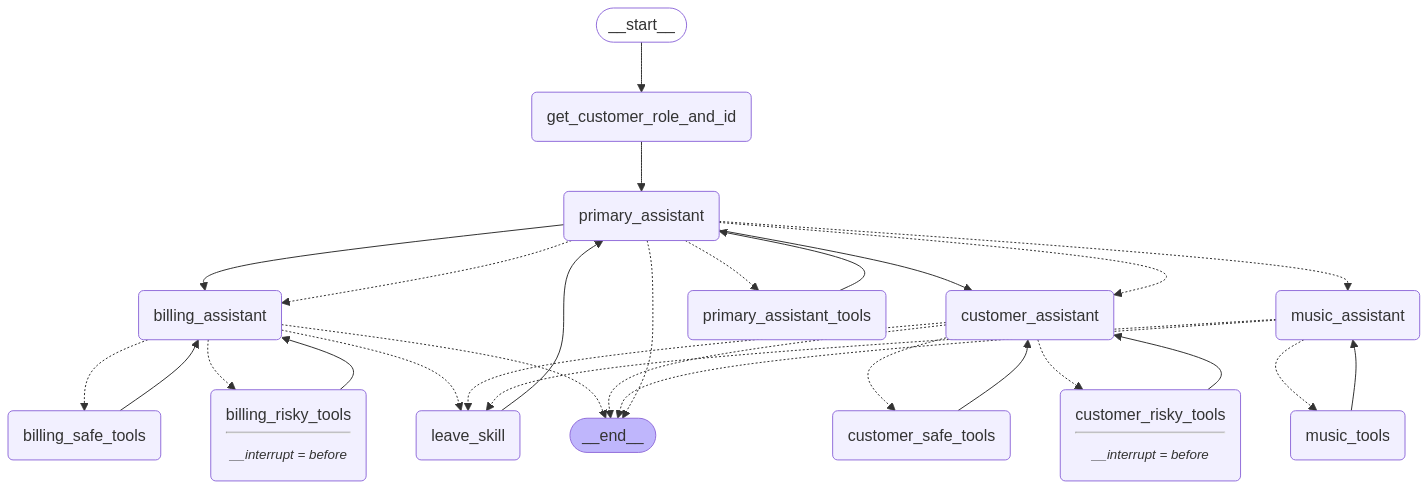

In [2]:
from IPython.display import Image, display

try:
    display(Image(workflow.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass